## MiniBatchKMeans Clustering

This notebook examines whether the data will sort itself into five clusters that correspond to the scores assigned by users.

TL;DR: Unsupervised clustering is not an effective model for predicting user scores based on review prose. 

In [1]:
from drug_objects import drug, review, drug_dataset

In [2]:
import sys, pickle, re, itertools
from collections import Counter, OrderedDict

import pandas as pd 

import numpy as np
from numpy import linspace, meshgrid

import pylab as pl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from matplotlib.mlab import griddata

%matplotlib inline

In [3]:
from sklearn import cluster, datasets, metrics
from sklearn.metrics import euclidean_distances, confusion_matrix, silhouette_samples, silhouette_score

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split

In [4]:
from textblob import TextBlob

In [5]:
from data_fxns import build_drug_dataset, binning_fxn, filter_count_scores, double_confusionPlot, plot_confusion_matrix

### Load Data

#### One dataset

In [6]:
one_drug, dataset = build_drug_dataset('single', 'drug_list_ddc_mini.p')

#### Merge generics

There are various drugs with the same active ingredient.  While they are different in how they are metabolized by the body, the below code allows user to consider these groups together.

In [8]:
one_drug, dataset = build_drug_dataset('generic', 'drug_list_ddc_pg1.p', 5)

duloxetine systemic 950 897
sertraline systemic 1225 1151
escitalopram systemic 1050 985
fluoxetine systemic 750 702
citalopram systemic 825 775
bupropion systemic 1300 1207
aripiprazole systemic 250 237
venlafaxine systemic 1000 947
desvenlafaxine systemic 600 557
mirtazapine systemic 325 302
vilazodone systemic 525 485


#### All drug dataset

Another option is to train the models on all of the drugs on the premise that the language used in all reviews is similar enough that the model would benefit from more instances of each score

In [7]:
one_drug, dataset = build_drug_dataset('all', 'drug_list_ddc_pg1.p')

duloxetine systemic 950 897
sertraline systemic 1225 1151
escitalopram systemic 1050 985
fluoxetine systemic 750 702
citalopram systemic 825 775
bupropion systemic 1300 1207
aripiprazole systemic 250 237
venlafaxine systemic 1000 947
desvenlafaxine systemic 600 557
mirtazapine systemic 325 302
vilazodone systemic 525 485


### Split off subsets

In [12]:
one_drug.attributeDetails['medDuration_str']

{None, '[0, 1]', '[1, 6]', '[120, 300]', '[24, 60]', '[6, 12]', '[60, 120]'}

In [13]:
attr = 'medDuration_str'

medDur_d = {}
for subset in one_drug.attributeDetails[attr]:
    medDur_d[str(subset)] = one_drug.slice_data(attr, subset)
    print(str(subset), len(medDur_d[str(subset)]))
    
frames = [medDur_d['[0, 1]'], medDur_d['[1, 6]'], medDur_d['[6, 12]']]

leq_1year = pd.concat(frames)
leq_1year.describe()

[0, 1] 175
[6, 12] 49
None 0
[24, 60] 40
[60, 120] 23
[120, 300] 19
[1, 6] 211


,genRating,upVotes
count,402.000000,435.000000
mean,6.721393,54.944828
std,3.245867,52.945209
min,1.000000,0.000000
25%,4.000000,15.000000
50%,8.000000,40.000000
75%,9.000000,85.500000
max,10.000000,279.000000


In [ ]:
# make dataset from a particular slice
dataset = drug_dataset(leq_1year)

In [14]:
len(one_drug.df), len(dataset.data)

(1300, 1207)

### Whether to leave with 10 labels, or bin them to 5 or 6

In [15]:
# Not re-binned labels
labels = dataset.target
target_names = dataset.target_names

In [10]:
# rebin for 5 bins (fron 10)
bin_conversion = OrderedDict({1:'1-2', 2:'1-2', 3:'3-4', 4:'3-4',5:'5-6', 6:'5-6', 7:'7-8', 8:'7-8', 9:'9-10', 10:'9-10'})
labels, target_names = binning_fxn(bin_conversion, dataset)

## Feature Extraction

In [11]:
# initialize TFIDF vectorizer
vectorizer = TfidfVectorizer(max_df=.5, max_features=3000,  ngram_range=(1, 2),
                                 min_df=2, stop_words='english')

In [12]:
# fit the vectorizer
fitted_vectorizer = vectorizer.fit(dataset.data)

# create matrix to fit LSA
X = fitted_vectorizer.transform(dataset.data)

In [13]:
n_components = 100

if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    lsa_fitted = lsa.fit(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 34%



In [14]:
# split the data (still in prose) in to test and training sets
X_train, X_test, y_train, y_test = train_test_split(dataset.data, labels, test_size=0.2, random_state=0)

# vectorize data
X_train_tfidf = fitted_vectorizer.transform(X_train)
X_test_tfidf = fitted_vectorizer.transform(X_test)

# LSA fit data
X_train_tfidf = lsa_fitted.transform(X_train_tfidf)
X_test_tfidf = lsa_fitted.transform(X_test_tfidf)

In [15]:
print("train: n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print("test: n_samples: %d, n_features: %d" % X_test_tfidf.shape)

train: n_samples: 965, n_features: 100
test: n_samples: 242, n_features: 100


## MiniBatchKMeans Clustering

In [16]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(target_names))
print()

true_k = list(set(labels))
true_k = np.unique(labels).shape[0]

1207 documents
5 categories



In [17]:
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)#, verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
km.fit(X_train_tfidf)
# km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, km.labels_, sample_size=1000))

print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

Homogeneity: 0.019
Completeness: 0.016
V-measure: 0.018
Adjusted Rand-Index: 0.014
Silhouette Coefficient: 0.012



In [18]:
y_pred = km.predict(X_test_tfidf)
y_true = y_test

In [19]:
# adjust labels to 1-5 scale
y_pred = [pred+1 for pred in y_pred]
print(set(y_pred))

{1, 2, 3, 4, 5}


### Visualize Clustering Predictions

In [20]:
N_CLUSTERS = len(target_names)
print(N_CLUSTERS)

5


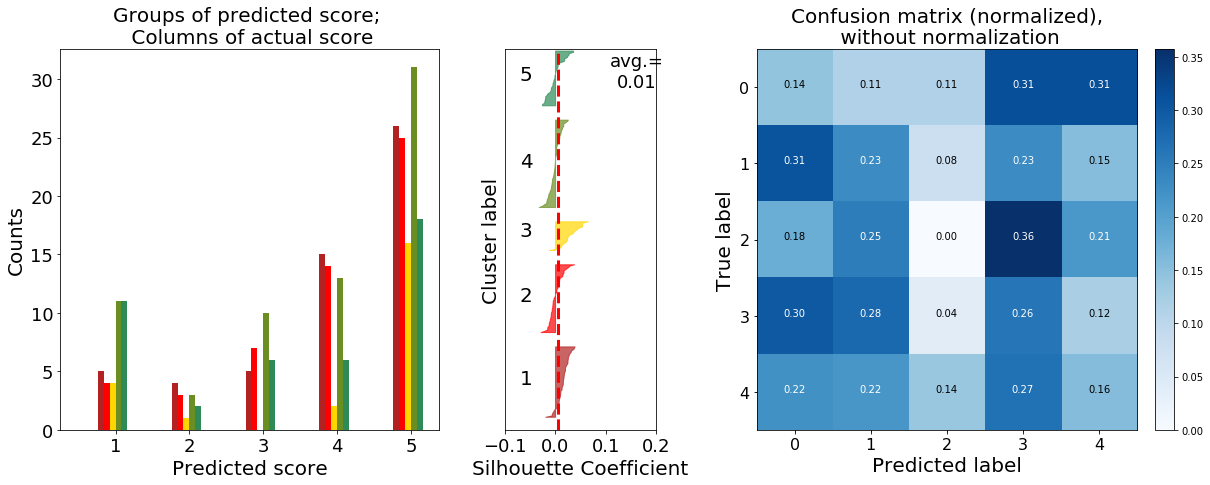

In [21]:
figSize = (2*N_CLUSTERS+10, 7)
title_sz = 27
axis_sz = 20
tick_sz = 18
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 3, width_ratios=[5, 2,6])

# Plot of Silhouette Coefficient for MiniBatchKMeans grouped by predicted score
score = metrics.silhouette_score(X_test_tfidf, y_pred, metric='euclidean')

ax2 = plt.subplot(gs[1])
ax2.set_xlim([-0.1, .2])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
try:
    ax2.set_ylim([0, len(X) + (N_CLUSTERS + 1) * 10])
except:
    ax2.set_ylim([0, X.shape[0] + (N_CLUSTERS + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_test_tfidf, y_pred)

y_lower = 10
y_pred = np.array(y_pred)

for i in range(1,1+N_CLUSTERS):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i-1]#cm.spectral(float(i) / N_CLUSTERS)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.07, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_ylim(0, y_upper)
ax2.text(.87, .90,'avg.=\n'+ '%.2f' % score, size=tick_sz, transform=plt.gca().transAxes,
    horizontalalignment='center')

#ax2.set_title("The silhouette plot for the various clusters.")
ax2.set_xlabel("Silhouette Coefficient", fontsize=axis_sz)
ax2.set_ylabel("Cluster label",fontsize=axis_sz)

# The vertical line for average silhoutte score of all the values
ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

ax2.set_yticks([])  # Clear the yaxis labels / ticks

xtickNames = ax2.get_xticklabels()
ytickNames = ax2.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)

# Bar Chart of predicted score counts (1-5) for each of the true scores
ax1 = plt.subplot(gs[0])
N = N_CLUSTERS
ind = np.arange(1,N+1)  # the x locations for the groups
width = 0.08       # the width of the bars
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

for score in np.arange(1,N+1):
    cts = filter_count_scores(score, y_pred, y_true, N_CLUSTERS)
    rects = ax1.bar((ind-.5*N*width)+(score-1)*width, cts, width, color=colors[score-1])

plt.xticks([ik-.15*5 for ik in np.arange(1,N_CLUSTERS+1)],  np.arange(1,N_CLUSTERS+1), rotation='vertical')
plt.xticks([ik for ik in np.arange(1,N_CLUSTERS+1)], np.arange(1,N_CLUSTERS+1), rotation='vertical')

ax1.set_xlabel('Predicted score', fontsize=axis_sz)
ax1.set_ylabel('Counts', fontsize=axis_sz)

plt.title('Groups of predicted score; \n Columns of actual score', fontsize=axis_sz) 

xtickNames = ax1.get_xticklabels()
ytickNames = ax1.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)

# Confusion Matrix
ax3 = plt.subplot(gs[2])
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(fig, ax3, cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix (normalized),\n without normalization')

## TextBlob Polarity 

In [22]:
# same code as in classifyer analysis in order to probe textblob-ypred comparisons for both types of models
blob_scores = []
blob_data = X_test
for ik in range(len(blob_data)):
    blob = TextBlob(blob_data[ik])
    blob_scores.append(blob.polarity)
    
blob_scores = np.array(blob_scores)
hist, bin_edges = np.histogram(blob_scores, bins=5) #int(len(blob_scores)/10))
bins = np.linspace(-1, 1, 5)
bin_inds = np.digitize(blob_scores, bins)

c = Counter(bin_inds)

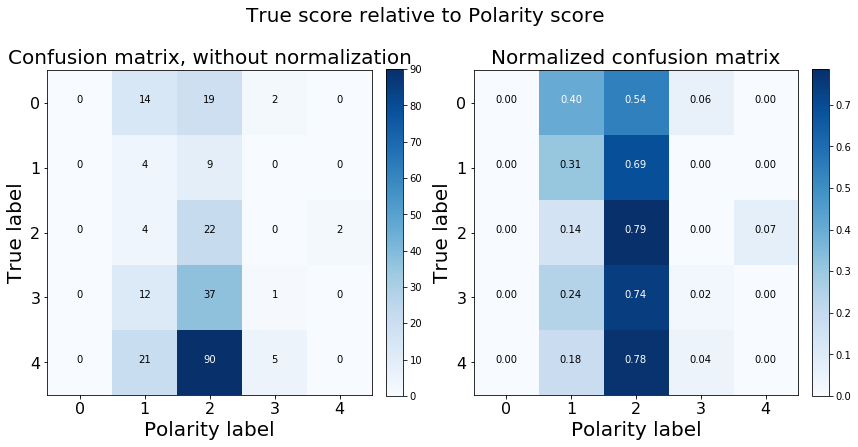

In [23]:
#Plot comparing real scores with TextBlob Polarity based scores
double_confusionPlot(y_test, bin_inds, 'True score relative to Polarity score', 'Polarity label', 'True label', target_names)

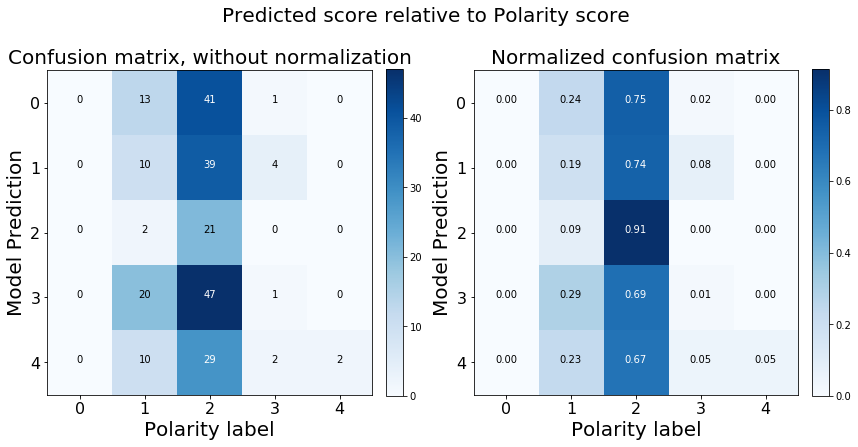

In [25]:
# Plot comparing MiniBatchKMeans predictions above with polarity scores
double_confusionPlot(y_pred, bin_inds, 'Predicted score relative to Polarity score', 'Polarity label', 'Model Prediction', target_names)